# Tutorial

DFTK is a Julia package for playing with plane-wave
density-functional theory algorithms. In its basic formulation it
solves periodic Kohn-Sham equations.

This document provides an overview of the structure of the code
and how to access basic information about calculations.
Basic familiarity with the concepts of plane-wave density functional theory
is assumed throughout. Feel free to take a look at the
[Periodic problems](https://docs.dftk.org/stable/guide/periodic_problems/)
or the
[Introductory resources](https://docs.dftk.org/stable/guide/introductory_resources/)
chapters for some introductory material on the topic.

> **Convergence parameters in the documentation**
>
> We use rough parameters in order to be able
> to automatically generate this documentation very quickly.
> Therefore results are far from converged.
> Tighter thresholds and larger grids should be used for more realistic results.

For our discussion we will use the classic example of computing the LDA ground state
of the [silicon crystal](https://www.materialsproject.org/materials/mp-149).
Performing such a calculation roughly proceeds in three steps.

In [1]:
using DFTK
using Plots
using Unitful
using UnitfulAtomic
using PseudoPotentialData

# 1. Define lattice and atomic positions
a = 5.431u"angstrom"          # Silicon lattice constant
lattice = a / 2 * [[0 1 1.];  # Silicon lattice vectors
                   [1 0 1.];  # specified column by column
                   [1 1 0.]];

By default, all numbers passed as arguments are assumed to be in atomic
units.  Quantities such as temperature, energy cutoffs, lattice vectors, and
the k-point grid spacing can optionally be annotated with Unitful units,
which are automatically converted to the atomic units used internally. For
more details, see the [Unitful package
documentation](https://painterqubits.github.io/Unitful.jl/stable/) and the
[UnitfulAtomic.jl package](https://github.com/sostock/UnitfulAtomic.jl).

We use a pseudodojo pseudopotential
(see [PseudoPotentialData](https://github.com/JuliaMolSim/PseudoPotentialData.jl)
 for more details on `PseudoFamily`):

In [2]:
pd_lda_family = PseudoFamily("dojo.nc.sr.lda.v0_4_1.standard.upf")
Si = ElementPsp(:Si, pd_lda_family)

# Specify type and positions of atoms
atoms     = [Si, Si]
positions = [ones(3)/8, -ones(3)/8]

2-element Vector{Vector{Float64}}:
 [0.125, 0.125, 0.125]
 [-0.125, -0.125, -0.125]

Note that DFTK supports a few other ways to supply atomistic structures,
see for example the sections on AtomsBase integration
and Input and output formats for details.

In [3]:
# 2. Select model and basis
model = model_DFT(lattice, atoms, positions; functionals=LDA())
kgrid = [4, 4, 4]     # k-point grid (Regular Monkhorst-Pack grid)
Ecut = 7              # kinetic energy cutoff
# Ecut = 190.5u"eV"  # Could also use eV or other energy-compatible units
basis = PlaneWaveBasis(model; Ecut, kgrid)
# Note the implicit passing of keyword arguments here:
# this is equivalent to PlaneWaveBasis(model; Ecut=Ecut, kgrid=kgrid)

# 3. Run the SCF procedure to obtain the ground state
scfres = self_consistent_field(basis, tol=1e-5);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.505271445517                   -0.93    5.2    4.11s
  2   -8.508283928681       -2.52       -1.79    1.0    4.49s
  3   -8.508458650187       -3.76       -2.90    1.6   52.7ms
  4   -8.508482976558       -4.61       -3.10    3.0   61.4ms
  5   -8.508483144721       -6.77       -3.34    1.1   22.8ms
  6   -8.508483219569       -7.13       -4.90    1.0   21.7ms
  7   -8.508483223713       -8.38       -4.75    3.4   41.6ms
  8   -8.508483223824       -9.95       -5.46    1.0   23.6ms


That's it! Now you can get various quantities from the result of the SCF.
For instance, the different components of the energy:

In [4]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             3.0841960 
    AtomicLocal         -2.3554861
    AtomicNonlocal      1.3116699 
    Ewald               -8.3979253
    PspCorrection       0.3948681 
    Hartree             0.5559207 
    Xc                  -3.1017265

    total               -8.508483223824

Eigenvalues:

In [5]:
stack(scfres.eigenvalues)

7×8 Matrix{Float64}:
 -0.264798  -0.235352   -0.179074   …  -0.189309   -0.112072  -0.106306
  0.174323   0.0295313  -0.0825375     -0.0265559  -0.112072  -0.106306
  0.174323   0.146147    0.129858       0.034739    0.068655   0.0309534
  0.174323   0.146147    0.129858       0.12521     0.068655   0.0309534
  0.267151   0.247826    0.229557       0.263041    0.198144   0.329876
  0.267151   0.302404    0.297036   …   0.349551    0.198144   0.329904
  0.267152   0.302404    0.297036       0.36216     0.541844   0.356808

`eigenvalues` is an array (indexed by k-points) of arrays (indexed by
eigenvalue number).

The resulting matrix is 7 (number of computed eigenvalues) by 8
(number of irreducible k-points). There are 7 eigenvalues per
k-point because there are 4 occupied states in the system (4 valence
electrons per silicon atom, two atoms per unit cell, and paired
spins), and the eigensolver gives itself some breathing room by
computing some extra states (see the `bands` argument to
`self_consistent_field` as well as the `AdaptiveBands` documentation).
There are only 8 k-points (instead of 4x4x4) because symmetry has been used to reduce the
amount of computations to just the irreducible k-points (see
[Crystal symmetries](https://docs.dftk.org/stable/developer/symmetries/)
for details).

We can check the occupations ...

In [6]:
stack(scfres.occupation)

7×8 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

... and density, where we use that the density objects in DFTK are
indexed as ρ[ix, iy, iz, iσ], i.e. first in the 3-dimensional real-space grid
and then in the spin component.

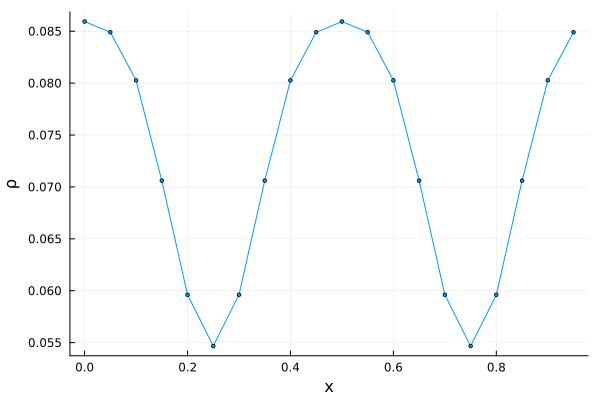

In [7]:
rvecs = collect(r_vectors(basis))[:, 1, 1]  # slice along the x axis
x = [r[1] for r in rvecs]                   # only keep the x coordinate
plot(x, scfres.ρ[1, :, 1, 1], label="", xlabel="x", ylabel="ρ", marker=2)

We can also perform various postprocessing steps:
We can get the Cartesian forces (in Hartree / Bohr):

In [8]:
compute_forces_cart(scfres)

2-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-2.1015703391978038e-14, -2.1096387941932286e-14, -2.0991388859215626e-14]
 [2.1183614170025807e-14, 2.1007099393293324e-14, 2.0941743215038714e-14]

As expected, they are numerically zero in this highly symmetric configuration.
We could also compute a band structure,

┌ Warning: Calling plot_bandstructure without first computing the band data is deprecated and will be removed in the next minor version bump.
└ @ DFTKPlotsExt ~/work/DFTK.jl/DFTK.jl/ext/DFTKPlotsExt.jl:27


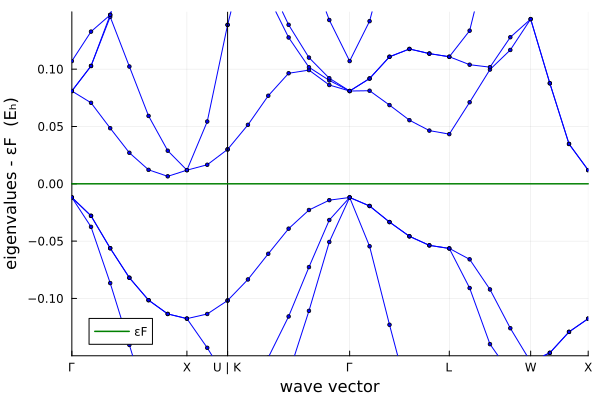

In [9]:
plot_bandstructure(scfres; kline_density=10)

or plot a density of states, for which we increase the kgrid a bit
to get smoother plots:

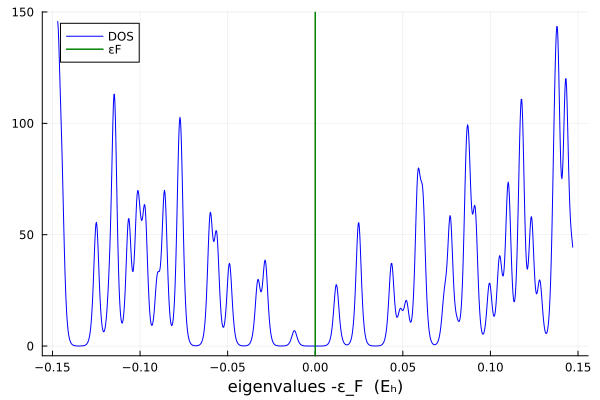

In [10]:
bands = compute_bands(scfres, MonkhorstPack(6, 6, 6))
plot_dos(bands; temperature=1e-3, smearing=Smearing.FermiDirac())

Note that directly employing the `scfres` also works, but the results
are much cruder:

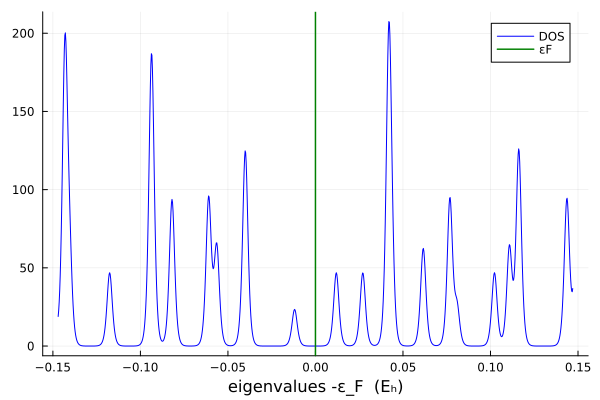

In [11]:
plot_dos(scfres; temperature=1e-3, smearing=Smearing.FermiDirac())